5/15 (Wed) | Experiment

# Preliminary Analyses of Rating

## 1. Introduction 

This notebook conducts preliminary analyses. 
More specifically, the current analyses aims the following goals.

1. Conduct Many Facet Rasch Analysis.
2. Count the number of ratings for each task and rater.
3. Calculate descriptive statistics of logit values.
4. Visualize the distribution of logit values for each task.
5. Decide threshold to split ratings.

Before starting the analyses, the following code block loads required packages and define global variables.

In [1]:
from typing import Dict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.mfr import logit_2_rating, ManyFacetRaschAnalyzer, visualize_item_characteristics_curves

DATA_DIR = Path("/home/matsuura/Development/app/feature_extraction_api/experiment/data")

TASK = ["Arg_Oly", "Cartoon", "RtSwithoutRAA", "RtSwithRAA", "WoZ_Interview"]

---

## 2. Define Functions

This section defines functions for the analyses.
The following code block defines a function to load perceived fluency rating data.

In [2]:
def load_logit_dataset() -> Dict[str, pd.DataFrame]:
    logit_dataset = {}

    for task in TASK:
        logit_csv_path = DATA_DIR / f"{task}/12_PF_Rating/logit.csv"
        df_logit = pd.read_csv(logit_csv_path)
        logit_dataset[task] = df_logit

    return logit_dataset

The following code block defines a function to count ratings for each rater.

In [3]:
def count_rating(logit_dataset: Dict[str, pd.DataFrame], task: str) -> None:
    df_logit = logit_dataset[task]
    rater_col = "Rater1"
    data = {}

    print(f"--- {task} ---")
    while rater_col in df_logit.columns:
        data[rater_col] = {}
        rating_set = sorted(set(df_logit[rater_col]))

        for rating in rating_set:
            mask_rating = (df_logit[rater_col] == rating)
            n_rating = mask_rating.sum()

            data[rater_col][rating] = n_rating

        rater_col = "Rater" + f"{int(rater_col[-1]) + 1}"
        
    threshold_path = DATA_DIR / f"{task}/12_PF_Rating/threshold.csv"
    rasch_rating = logit_2_rating(df_logit["theta"], threshold_path)
    
    data["Rasch"] = {}
    rating_set = sorted(set(rasch_rating))
    for rating in rating_set:
        mask_rating = (rasch_rating == rating)
        n_rating = mask_rating.sum()

        data["Rasch"][rating] = n_rating

    df_rating_count = pd.DataFrame(data).sort_index().T
    return df_rating_count

The following code block defines a function to calculate descriptive statistics of logit values.

In [4]:
def calculate_descriptive_stats(logit_dataset: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    logit_series = []
    
    for task in TASK:
        df_task = logit_dataset[task]
        logit_series.append(df_task["theta"])

    df_logits = pd.concat(logit_series, axis=1)
    df_logits.columns = TASK

    return df_logits.describe().T

The following code block defines a function to visualize the distribution of logit values.

In [5]:
def visualize_logit_distribution(logit_dataset: Dict[str, pd.DataFrame], task: str) -> None:
    df_logit = logit_dataset[task]
    
    fig, ax = plt.subplots(1, 1)
    ax = sns.histplot(
        data=df_logit,
        x="theta",
        palette="winter",
        alpha=0.3,
        kde=True
    )

    ax.set_title(f"Distribtuion of logit values in {task}")
    fig.tight_layout()

    plt.plot()

The following code block defines a function to obtain percentile of logit values.

In [6]:
def get_percentile(logit_dataset: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    percentile_list = []
    
    for task in TASK:
        df_task = logit_dataset[task]
        percentile = df_task["theta"].quantile([0.25, 0.5, 0.75])
        percentile_list.append(percentile)

    df_percentiles = pd.concat(percentile_list, axis=1)
    df_percentiles.columns = TASK

    return df_percentiles

---

## 3. Rasch Analyses

This section conduct Rasch analyses.
The following code block constructs ManyFacetRaschAnalyzer.

In [7]:
tam = ManyFacetRaschAnalyzer(debug=False)

The following code block conducts Many Facet Rasch Analysis and saves parameters.

In [8]:
for task in TASK:
    pf_path = DATA_DIR / f"{task}/12_PF_Rating/pf_rating.csv"
    logit_path = pf_path.parent / "logit.csv"
    threshold_path = pf_path.parent / "threshold.csv"
    item_params_path = pf_path.parent / "item_params.csv"

    if logit_path.exists():
        continue

    df_rating = pd.read_csv(pf_path, index_col=0)
    target_columns = df_rating.columns.to_numpy()

    df_logit, df_threshold, df_item_params = tam.fit(df_rating, target_columns=target_columns)

    df_logit.to_csv(logit_path)
    df_threshold.to_csv(threshold_path)
    df_item_params.to_csv(item_params_path)

The following code block visualize item characteristics curves.

[]

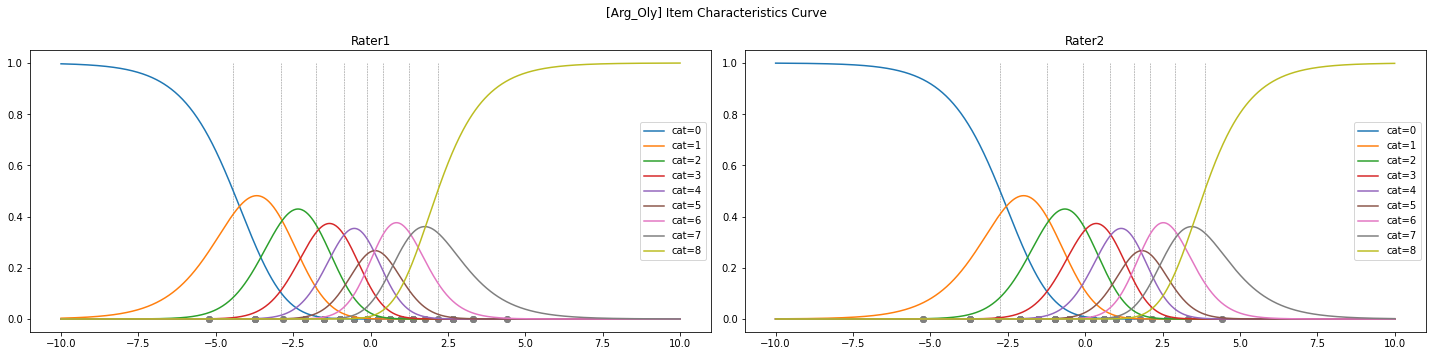

In [9]:
logit_path = DATA_DIR / "Arg_Oly/12_PF_Rating/logit.csv"
threshold_path = logit_path.parent / "threshold.csv"
item_params_path = logit_path.parent / "item_params.csv"

df_logit = pd.read_csv(logit_path, index_col=0)
df_threshold = pd.read_csv(threshold_path, index_col=0)
df_item_params = pd.read_csv(item_params_path, index_col=0)

raters = ["Rater1", "Rater2"]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for idx, rater in enumerate(raters):
    df_item_params_rater = df_item_params.loc[rater, :]
    axes[idx] = visualize_item_characteristics_curves(axes[idx], df_item_params_rater, 9)
    axes[idx].set_title(f"{rater}")

    axes[idx].vlines(df_threshold.loc[rater, :], 0, 1, linestyle="dashed", linewidth=0.5, color="gray")
    axes[idx].scatter(df_logit["theta"], np.zeros_like(df_logit["theta"]), color="gray")

fig.suptitle(f"[Arg_Oly] Item Characteristics Curve")
fig.tight_layout()
plt.plot()

[]

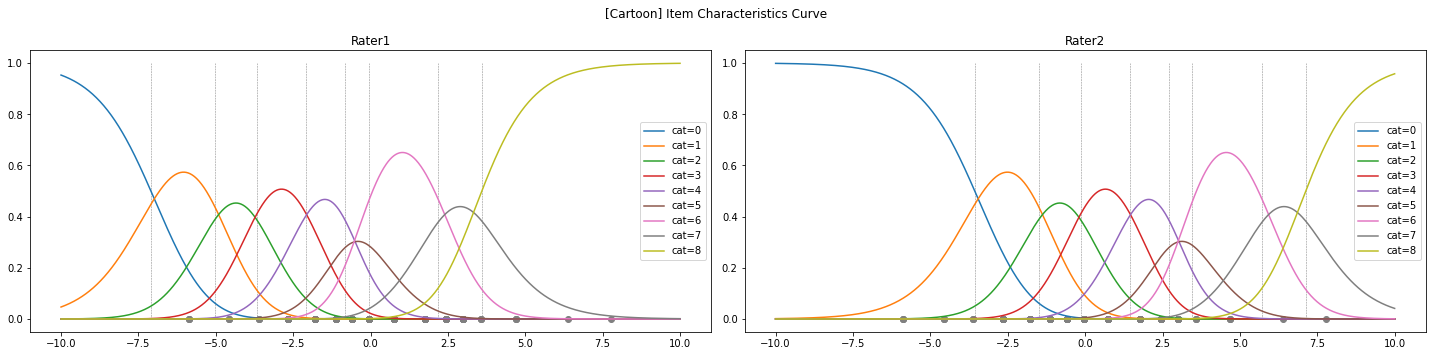

In [10]:
logit_path = DATA_DIR / "Cartoon/12_PF_Rating/logit.csv"
threshold_path = logit_path.parent / "threshold.csv"
item_params_path = logit_path.parent / "item_params.csv"

df_logit = pd.read_csv(logit_path, index_col=0)
df_threshold = pd.read_csv(threshold_path, index_col=0)
df_item_params = pd.read_csv(item_params_path, index_col=0)

raters = ["Rater1", "Rater2"]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for idx, rater in enumerate(raters):
    df_item_params_rater = df_item_params.loc[rater, :]
    axes[idx] = visualize_item_characteristics_curves(axes[idx], df_item_params_rater, 9)
    axes[idx].set_title(f"{rater}")

    axes[idx].vlines(df_threshold.loc[rater, :], 0, 1, linestyle="dashed", linewidth=0.5, color="gray")
    axes[idx].scatter(df_logit["theta"], np.zeros_like(df_logit["theta"]), color="gray")

fig.suptitle(f"[Cartoon] Item Characteristics Curve")
fig.tight_layout()
plt.plot()

[]

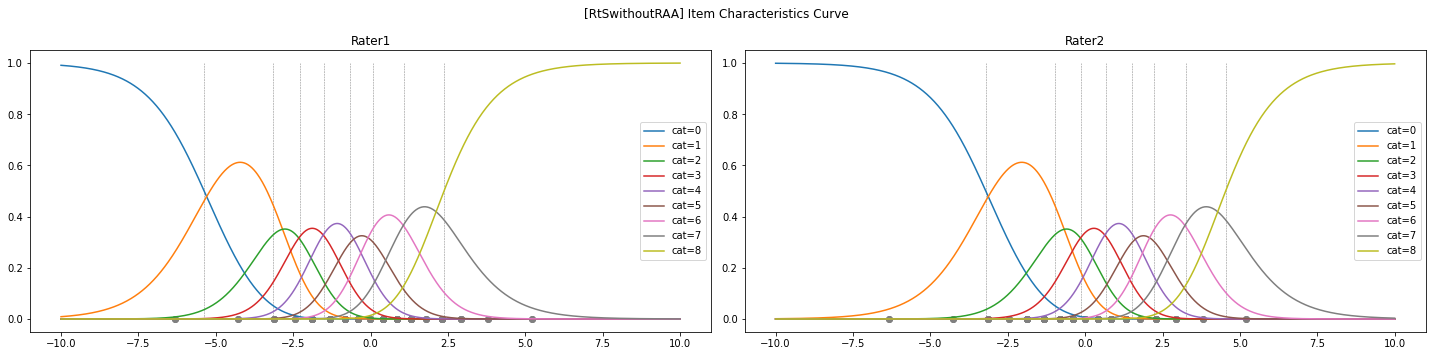

In [11]:
logit_path = DATA_DIR / "RtSwithoutRAA/12_PF_Rating/logit.csv"
threshold_path = logit_path.parent / "threshold.csv"
item_params_path = logit_path.parent / "item_params.csv"

df_logit = pd.read_csv(logit_path, index_col=0)
df_threshold = pd.read_csv(threshold_path, index_col=0)
df_item_params = pd.read_csv(item_params_path, index_col=0)

raters = ["Rater1", "Rater2"]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for idx, rater in enumerate(raters):
    df_item_params_rater = df_item_params.loc[rater, :]
    axes[idx] = visualize_item_characteristics_curves(axes[idx], df_item_params_rater, 9)
    axes[idx].set_title(f"{rater}")

    axes[idx].vlines(df_threshold.loc[rater, :], 0, 1, linestyle="dashed", linewidth=0.5, color="gray")
    axes[idx].scatter(df_logit["theta"], np.zeros_like(df_logit["theta"]), color="gray")

fig.suptitle(f"[RtSwithoutRAA] Item Characteristics Curve")
fig.tight_layout()
plt.plot()

[]

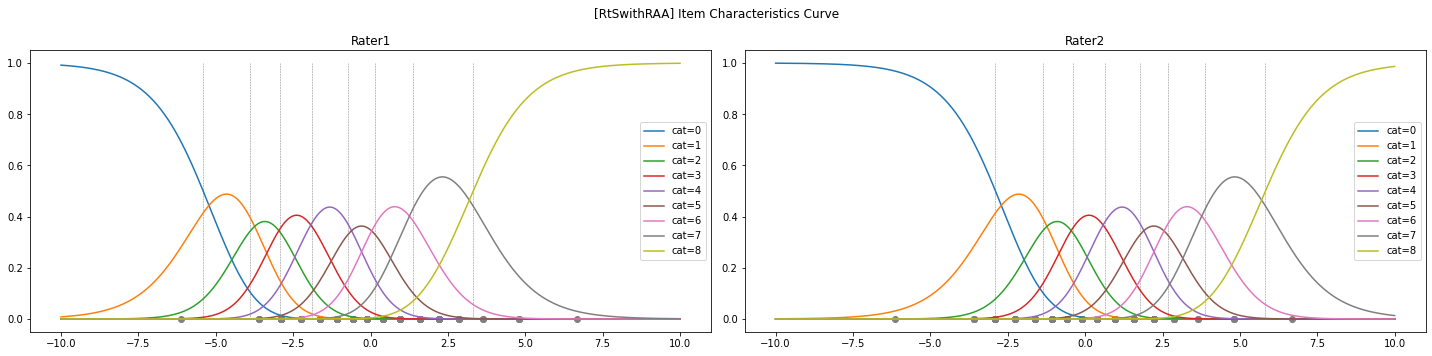

In [12]:
logit_path = DATA_DIR / "RtSwithRAA/12_PF_Rating/logit.csv"
threshold_path = logit_path.parent / "threshold.csv"
item_params_path = logit_path.parent / "item_params.csv"

df_logit = pd.read_csv(logit_path, index_col=0)
df_threshold = pd.read_csv(threshold_path, index_col=0)
df_item_params = pd.read_csv(item_params_path, index_col=0)

raters = ["Rater1", "Rater2"]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for idx, rater in enumerate(raters):
    df_item_params_rater = df_item_params.loc[rater, :]
    axes[idx] = visualize_item_characteristics_curves(axes[idx], df_item_params_rater, 9)
    axes[idx].set_title(f"{rater}")

    axes[idx].vlines(df_threshold.loc[rater, :], 0, 1, linestyle="dashed", linewidth=0.5, color="gray")
    axes[idx].scatter(df_logit["theta"], np.zeros_like(df_logit["theta"]), color="gray")

fig.suptitle(f"[RtSwithRAA] Item Characteristics Curve")
fig.tight_layout()
plt.plot()

[]

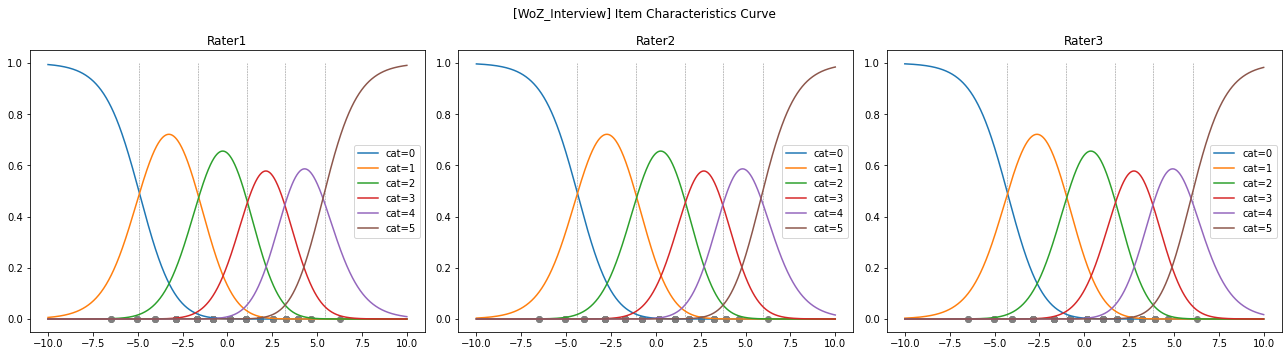

In [29]:
logit_path = DATA_DIR / "WoZ_Interview/12_PF_Rating/logit.csv"
threshold_path = logit_path.parent / "threshold.csv"
item_params_path = logit_path.parent / "item_params.csv"

df_logit = pd.read_csv(logit_path, index_col=0)
df_threshold = pd.read_csv(threshold_path, index_col=0)
df_item_params = pd.read_csv(item_params_path, index_col=0)

raters = ["Rater1", "Rater2", "Rater3"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, rater in enumerate(raters):
    df_item_params_rater = df_item_params.loc[rater, :]
    axes[idx] = visualize_item_characteristics_curves(axes[idx], df_item_params_rater, 6)
    axes[idx].set_title(f"{rater}")

    axes[idx].vlines(df_threshold.loc[rater, :], 0, 1, linestyle="dashed", linewidth=0.5, color="gray")
    axes[idx].scatter(df_logit["theta"], np.zeros_like(df_logit["theta"]), color="gray")

fig.suptitle(f"[WoZ_Interview] Item Characteristics Curve")
fig.tight_layout()
plt.plot()

--- 

## 3. Preliminary Analyses

This section conduct the preliminary analyses.
Before startint the analyses, the following code block loads dataset.

In [14]:
logit_dataset = load_logit_dataset()

### 3.1. Count Ratings

In [15]:
count_rating(logit_dataset, "Arg_Oly")

--- Arg_Oly ---


,0,1,2,3,4,5,6,7,8
Rater1,5,12,6,9,23,17,24,17,15
Rater2,9,15,34,33,16,9,6,3,3
Rasch,9,10,16,27,26,13,13,9,5


In [16]:
count_rating(logit_dataset, "Cartoon")

--- Cartoon ---


,0,1,2,3,4,5,6,7,8
Rater1,NaN,4.0,5.0,10.0,29.0,16.0,41.0,15.0,8.0
Rater2,10.0,22.0,29.0,37.0,13.0,9.0,6.0,1.0,1.0
Rasch,3.0,6.0,9.0,37.0,41.0,NaN,27.0,3.0,2.0


In [17]:
count_rating(logit_dataset, "RtSwithoutRAA")

--- RtSwithoutRAA ---


,0,1,2,3,4,5,6,7,8
Rater1,2,7,3,11,20,22,28,23,12
Rater2,7,26,27,25,20,11,7,2,3
Rasch,2,9,20,15,36,17,15,10,4


In [18]:
count_rating(logit_dataset, "RtSwithRAA")

--- RtSwithRAA ---


,0,1,2,3,4,5,6,7,8
Rater1,1.0,NaN,7.0,13.0,23.0,28.0,26.0,23.0,7.0
Rater2,10.0,23.0,22.0,27.0,24.0,8.0,9.0,3.0,2.0
Rasch,1.0,11.0,6.0,23.0,45.0,13.0,19.0,6.0,4.0


In [19]:
count_rating(logit_dataset, "WoZ_Interview")

--- WoZ_Interview ---


,0,1,2,3,4,5
Rater1,6,15,36,14,12,2
Rater2,8,25,24,17,9,2
Rater3,2,29,29,21,3,1
Rasch,5,21,34,15,9,1


### 3.2. Descriptive Statistics

In [20]:
calculate_descriptive_stats(logit_dataset)

,count,mean,std,min,25%,50%,75%,max
Arg_Oly,128.0,-0.019729,1.823720,-5.227343,-0.978360,0.246425,0.999067,4.418617
Cartoon,128.0,-0.015982,2.336048,-5.875116,-1.789636,-0.038919,0.997513,7.769266
RtSwithoutRAA,128.0,-0.015223,1.834958,-6.322633,-0.823598,0.404531,0.842499,5.201548
RtSwithRAA,128.0,0.009144,1.950986,-6.135403,-1.071049,-0.105759,0.965339,6.674476
WoZ_Interview,85.0,0.031474,2.724042,-6.491508,-1.703447,0.151422,1.821602,6.270262


### 3.3. Visualization of Logit Distribution

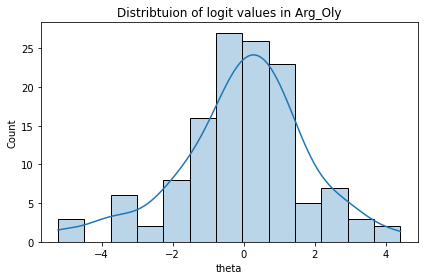

In [21]:
visualize_logit_distribution(logit_dataset, "Arg_Oly")

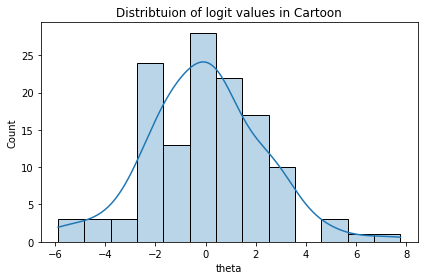

In [22]:
visualize_logit_distribution(logit_dataset, "Cartoon")

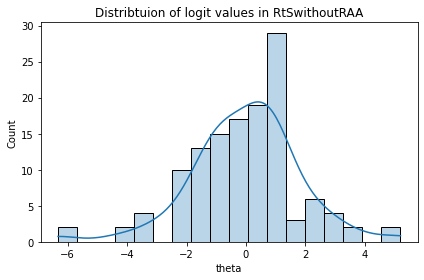

In [23]:
visualize_logit_distribution(logit_dataset, "RtSwithoutRAA")

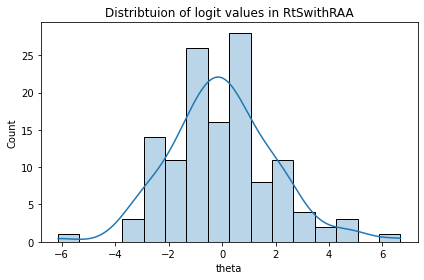

In [24]:
visualize_logit_distribution(logit_dataset, "RtSwithRAA")

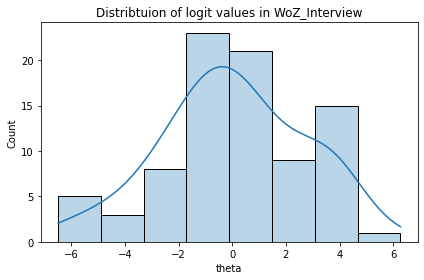

In [25]:
visualize_logit_distribution(logit_dataset, "WoZ_Interview")

### 3.4. Obtaining Percentiles

In [26]:
df_percentiles = get_percentile(logit_dataset)
df_percentiles

,Arg_Oly,Cartoon,RtSwithoutRAA,RtSwithRAA,WoZ_Interview
0.25,-0.978360,-1.789636,-0.823598,-1.071049,-1.703447
0.50,0.246425,-0.038919,0.404531,-0.105759,0.151422
0.75,0.999067,0.997513,0.842499,0.965339,1.821602


In [27]:
# df_percentiles.to_csv(DATA_DIR / "logit_percentiles.csv", index=False)